# ANÁLISE PARA ABASTECIMENTO DO ESTOQUE GIGFARMA

#### Bibliotecas utilizadas e variáveis globais


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import itertools
import json


from scipy import special
from urllib.request import urlopen
from datetime import date
from datetime import timedelta
from pandas.plotting import autocorrelation_plot
from IPython.display import display
from random import sample

## Machinelearn 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import OneClassSVM

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets

from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA

#precisou instalar o tensor flow conda install jupyter tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from mpl_toolkits.mplot3d import Axes3D

import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# url do serviço spark, está local devido ao código estar 
# rodando em uma maquina virtual o ip abaixo está disponível no meu ambiente
# baixe a api com os datasets para executar em conjunto 
url_produto_filial = 'http://172.24.0.1:8083/vendas/v1/6892/filial/115'
url_produto = 'http://172.24.0.1:8083/produtos/v1/6892'

#### Definição de funções uteis nas análises

In [2]:
def get_data(url_data):
    response = urlopen(url_data)
    data_json = json.loads(response.read())
    resultado = [ast.literal_eval(data) for data in data_json]
    return pd.DataFrame(resultado)

def get_data_only(url_data):
    response = urlopen(url_data)
    data_json = json.loads(response.read())
    resultado = data_json
    dataSingle = pd.DataFrame.from_dict(resultado, orient='index')
    dataSingle.columns = ["values"]
    return dataSingle

def generateSequence(dataFrame,field):
    dataFrame[field] =  pd.Series(range(1,dataFrame.size))
    return dataFrame

def transformDateTime(dataFrame,field,newField):
    dataFrame[newField] = pd.to_datetime(dataFrame[field])
    return dataFrame

def create_feature(dataset, label=None):
    df = dataset.copy()
    df['DIA_SEMANA'] = df['DATA_EMISSAO'].dt.dayofweek
    df['MES'] = df['DATA_EMISSAO'].dt.month
    df['DIA_MES'] = df['DATA_EMISSAO'].dt.day
    
    
    X = df[['CODIGO_FILIAL', 'DIA_SEMANA','MES','DIA_MES','CRESCIMENTO','MEDIA_SEMANA','MEDIA_MES','CRESCIMENTO_PERCENTUAL']]
    X.fillna(0, inplace=True)    
    
    if label:
        y = df[label]
        return X,y
    
    return X


def enrich_information(dataset):
    dataset = dataset.sort_values(by='DATA_EMISSAO')
    dataset =  generateSequence(dataset,'SEQUENCIA')    
    dataset = transformDateTime(dataset,'DATA_EMISSAO','DATA_EMISSAO')
    dataset['CRESCIMENTO'] = dataset['QUANTIDADE'].diff()
    dataset['MEDIA_SEMANA'] = dataset["QUANTIDADE"].rolling(window=7,center=False).mean()
    dataset['MEDIA_MES'] = dataset["QUANTIDADE"].rolling(window=30,center=False).mean()
    dataset['CRESCIMENTO_PERCENTUAL'] = dataset['QUANTIDADE'].shift(-1).div(dataset['QUANTIDADE']) -1
    return dataset
    

#### Definição de funções úteis para plot dos gráficos

In [3]:
def plot_line(titulo, xLabel, yLabel, xData,yData,dataset,hue, label):
    ax = sns.lineplot(x=xData, y=yData,  hue=hue, data=dataset, label=label)
    ax.figure.set_size_inches(18,5)
    ax.set_title(titulo, loc='left',fontsize=20)
    ax.set_xlabel(xLabel  ,fontsize=20)
    ax.set_ylabel(yLabel  ,fontsize=20, rotation=90)
    plt.xticks(rotation=70)
    
    
def plot_barr(titulo, xLabel, yLabel, xData,yData,dataset):
    plt.figure(figsize=(20,6))
    ax = plt.bar(dataset[xData],dataset[yData])    
    plt.title(titulo,loc='left',fontsize=20)
    plt.xlabel(xLabel  ,fontsize=20)
    plt.ylabel(yLabel  ,fontsize=20, rotation=90)
    plt.xticks(rotation=70)
    
def plot_correlation(title,dataset):
    ax = plt.figure(figsize=(12,6))
    ax.suptitle(title, fontsize=18,x=0.05,y=0.95)
    autocorrelation_plot(dataset)
    ax = ax
    plt.xticks(rotation=70)

#### Busca dados consolidados por produto da api spark que possui o dataset com todas as vendas

In [4]:
dados_produto = get_data_only(url_produto)
dados_produto


,values
CODIGO_PRODUTO,6892
CLASSIFICACAO_FISCAL,30043999
COMERCIALIZACAO,11
CLASSIFICACAO_PRODUTO,1
TARJA,2
GRUPO,1
DESCRICAO,"CELESTONE 4,0MG 1AMP"
DESCRICAO_TECNICA,CELESTONE 4 MG 1 AMPOLA
DESCRICAO_DETALHADA,CELESTONE 4 MG 1 AMPOLA
DESCRICAO_FONETICA,Celestone 4mg


In [5]:
dados_produto_filial = get_data(url_produto_filial)

#### Enriquecendo o dataset com campos uteis para análise


In [6]:
dados_produto_filial = enrich_information(dados_produto_filial)

In [7]:
dados_produto_filial.head()

,DATA_EMISSAO,CODIGO_FILIAL,CODIGO_PRODUTO,QUANTIDADE,SEQUENCIA,CRESCIMENTO,MEDIA_SEMANA,MEDIA_MES,CRESCIMENTO_PERCENTUAL
0,2010-01-01,115,6892,2.0,1,NaN,NaN,NaN,0.0
1,2010-01-03,115,6892,2.0,2,0.0,NaN,NaN,-0.5
2,2010-01-06,115,6892,1.0,3,-1.0,NaN,NaN,0.0
3,2010-01-07,115,6892,1.0,4,0.0,NaN,NaN,0.0
4,2010-01-10,115,6892,1.0,5,0.0,NaN,NaN,0.0


### Identificando a movimentação pelas vendas diária

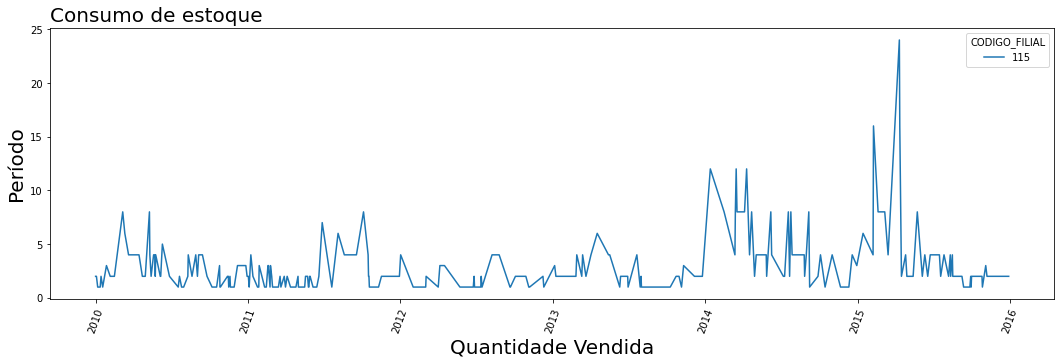

In [8]:
plot_line('Consumo de estoque', 'Quantidade Vendida',
          'Período', 'DATA_EMISSAO','QUANTIDADE',dados_produto_filial,'CODIGO_FILIAL', None)

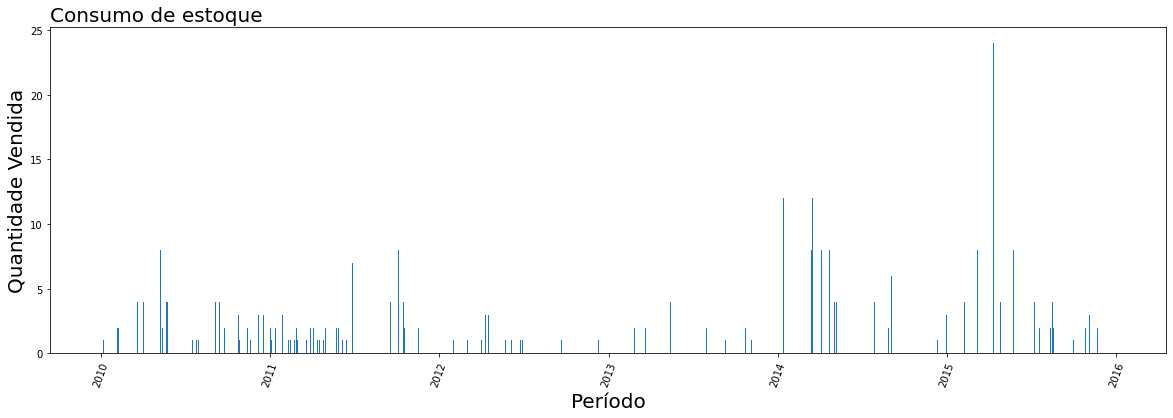

In [9]:
plot_barr('Consumo de estoque', 
          'Período', 'Quantidade Vendida', 'DATA_EMISSAO','QUANTIDADE',dados_produto_filial)

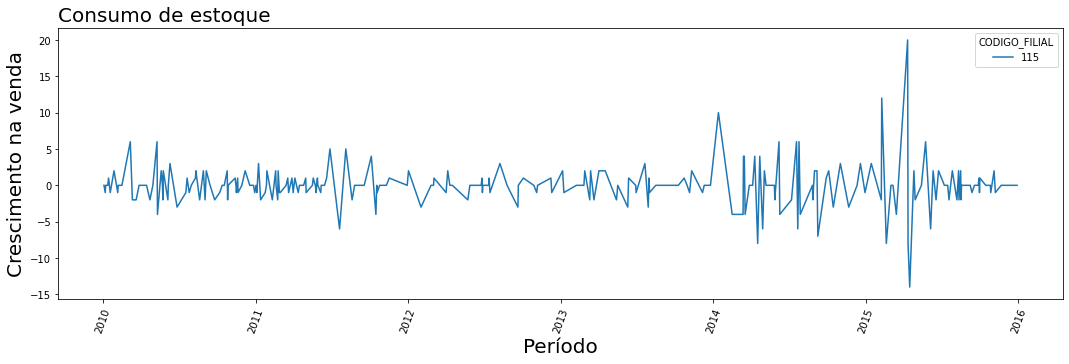

In [10]:
plot_line('Consumo de estoque', 'Período',
          'Crescimento na venda', 'DATA_EMISSAO','CRESCIMENTO',dados_produto_filial,'CODIGO_FILIAL', None)

#### Validando com média móvel para identificar possíveis sazionalidades

<BarContainer object of 276 artists>

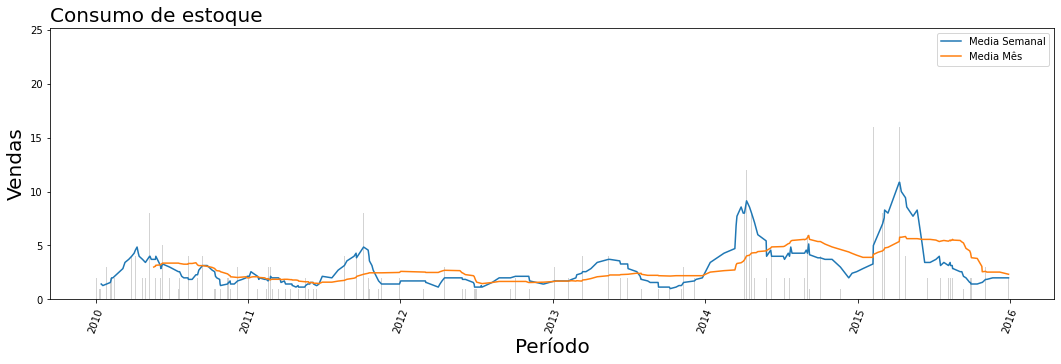

In [11]:
plot_line('Consumo de estoque', 'Período',
          'Vendas', 'DATA_EMISSAO','MEDIA_SEMANA',dados_produto_filial,None, 'Media Semanal')
plot_line('Consumo de estoque', 'Período',
          'Vendas', 'DATA_EMISSAO','MEDIA_MES',dados_produto_filial,None, 'Media Mês')

plt.bar(dados_produto_filial['DATA_EMISSAO'],dados_produto_filial['QUANTIDADE'],color='lightgrey')

### Autocorrelação entre os períodos com lag 

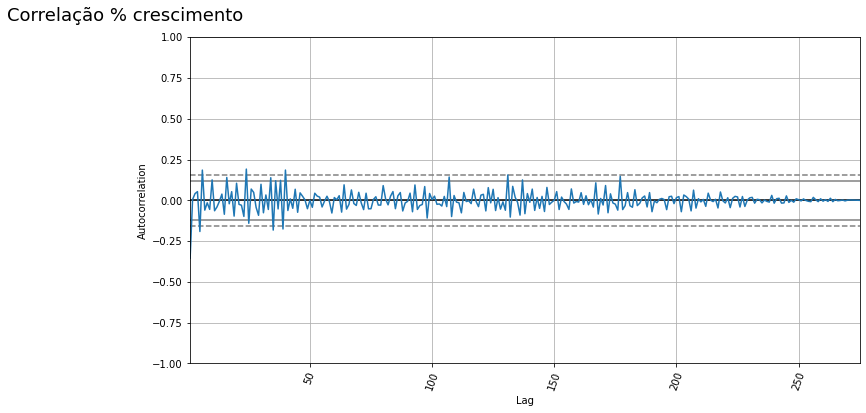

In [12]:
plot_correlation('Correlação % crescimento',dados_produto_filial['CRESCIMENTO_PERCENTUAL'][:-1])


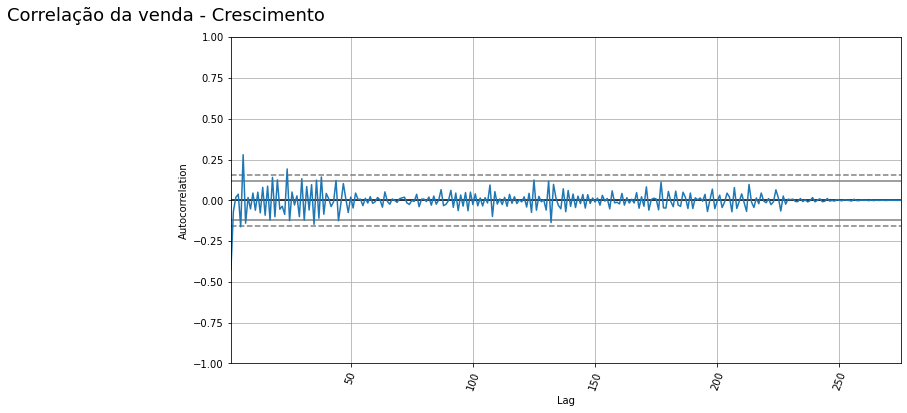

In [13]:
plot_correlation('Correlação da venda - Crescimento',dados_produto_filial['CRESCIMENTO'][1:])

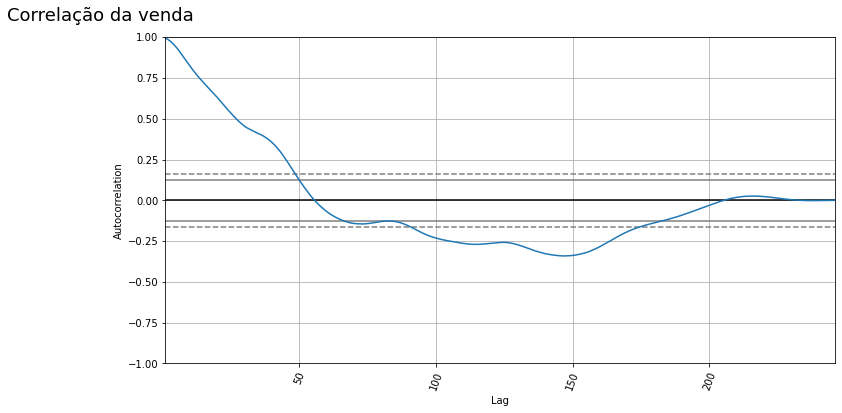

In [14]:
plot_correlation('Correlação da venda',dados_produto_filial['MEDIA_MES'][30:])

In [15]:
X, y = create_feature(dados_produto_filial,label='QUANTIDADE')

In [16]:
dados_features_label = pd.concat([X,y],axis=1)

In [17]:
dados_features_label.head(10)

,CODIGO_FILIAL,DIA_SEMANA,MES,DIA_MES,CRESCIMENTO,MEDIA_SEMANA,MEDIA_MES,CRESCIMENTO_PERCENTUAL,QUANTIDADE
0,115,4,1,1,0.0,0.000000,0.0,0.000000,2.0
1,115,6,1,3,0.0,0.000000,0.0,-0.500000,2.0
2,115,2,1,6,-1.0,0.000000,0.0,0.000000,1.0
3,115,3,1,7,0.0,0.000000,0.0,0.000000,1.0
4,115,6,1,10,0.0,0.000000,0.0,0.000000,1.0
5,115,1,1,12,0.0,0.000000,0.0,1.000000,1.0
6,115,3,1,14,1.0,1.428571,0.0,-0.500000,2.0
7,115,0,1,18,-1.0,1.285714,0.0,2.000000,1.0
8,115,2,1,27,2.0,1.428571,0.0,-0.333333,3.0
9,115,4,2,5,-1.0,1.571429,0.0,0.000000,2.0


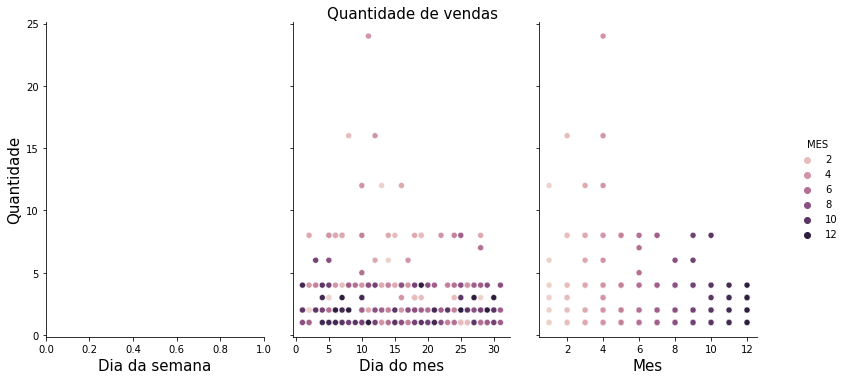

In [18]:
gr = sns.pairplot(dados_features_label, 
                  hue='MES', 
                  x_vars=['DIA_SEMANA','DIA_MES','MES'],
                  y_vars='QUANTIDADE')
gr.fig.set_size_inches(12,6)
gr.axes[0,0].set_xlabel('Dia da semana', fontsize=15)
gr.axes[0,1].set_xlabel('Dia do mes', fontsize=15)
gr.axes[0,2].set_xlabel('Mes', fontsize=15)
gr.axes[0,0].set_ylabel('Quantidade', fontsize=15)
plt.suptitle('Quantidade de vendas', fontsize=15)
plt.show()

Text(0, 0.5, 'Total')

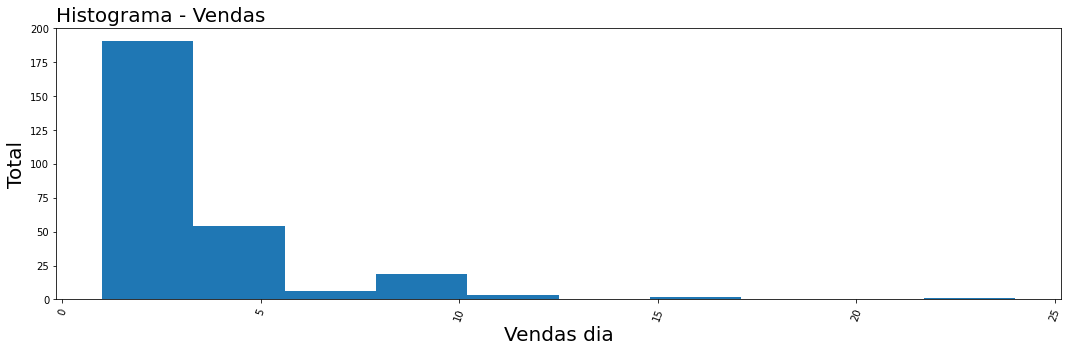

In [19]:
ax = dados_features_label['QUANTIDADE'].plot(kind='hist')
plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("Histograma - Vendas", loc='left',fontsize=20)
ax.set_xlabel("Vendas dia"  ,fontsize=20)
ax.set_ylabel("Total",fontsize=20, rotation=90)

Text(0, 0.5, 'Total')

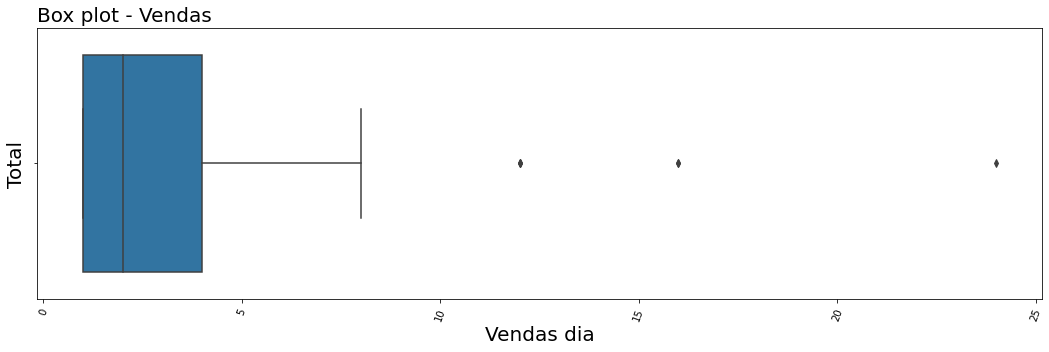

In [20]:
ax = sns.boxplot(dados_features_label['QUANTIDADE'])
plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("Box plot - Vendas", loc='left',fontsize=20)
ax.set_xlabel("Vendas dia"  ,fontsize=20)
ax.set_ylabel("Total",fontsize=20, rotation=90)

Text(0, 0.5, 'Total')

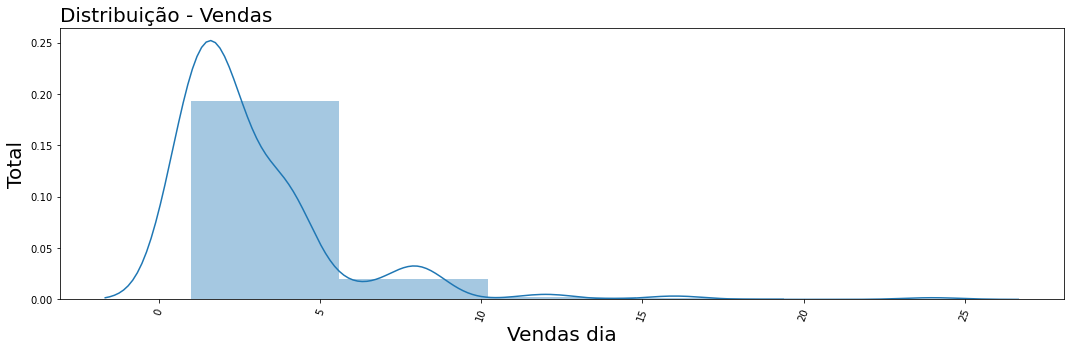

In [21]:

ax = sns.distplot(dados_features_label['QUANTIDADE'], bins=5)
plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("Distribuição - Vendas", loc='left',fontsize=20)
ax.set_xlabel("Vendas dia"  ,fontsize=20)
ax.set_ylabel("Total",fontsize=20, rotation=90)

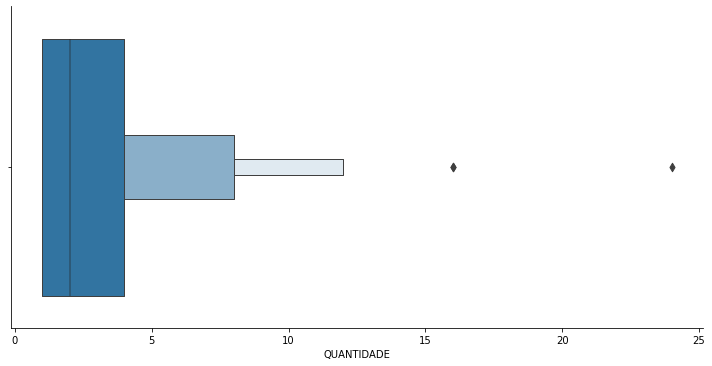

In [22]:
ax = sns.catplot(x = 'QUANTIDADE', kind='boxen',
           data = dados_features_label,
           aspect = 2)




Text(0, 0.5, 'Quantidade')

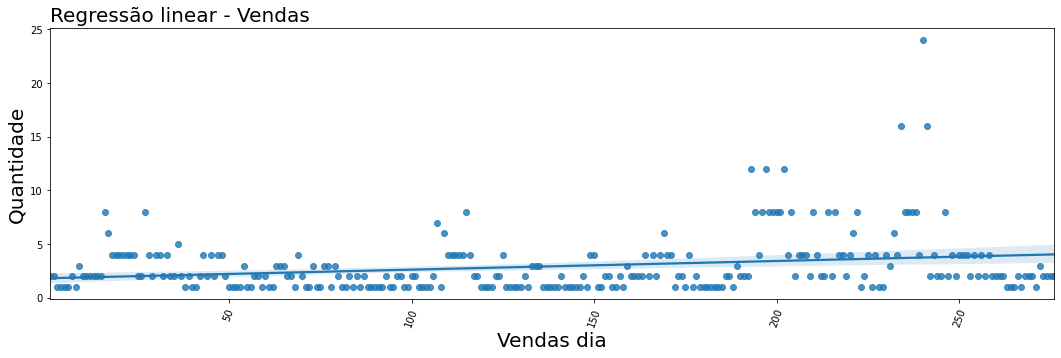

In [23]:

ax = sns.regplot(x="SEQUENCIA",
            y="QUANTIDADE", 
            
            data=dados_produto_filial);

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("Regressão linear - Vendas", loc='left',fontsize=20)
ax.set_xlabel("Vendas dia"  ,fontsize=20)
ax.set_ylabel("Quantidade",fontsize=20, rotation=90)


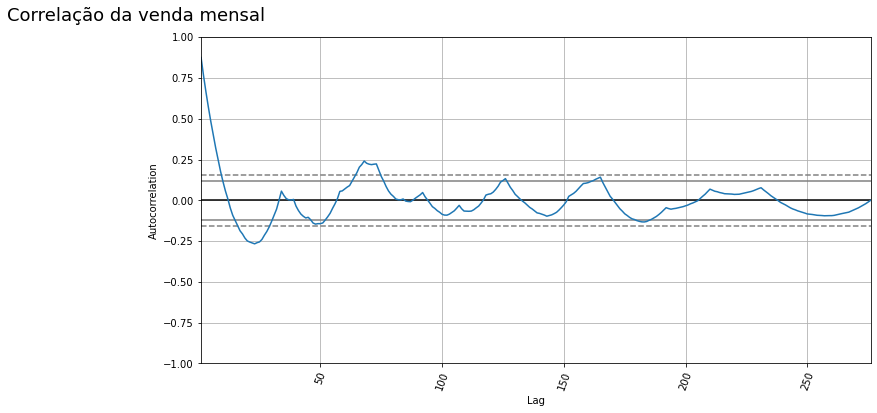

In [24]:
plot_correlation('Correlação da venda mensal',dados_features_label['MES'])

#### Conclusão pelas análises acima é que:
 O produto não possui variável que possamos correlacionar e não tem um comportamento sazional e que as vendas vem caindo conforme o tempo.
 As vendas diárias se concentra em até 2 itens e temos outliers com mais de 7 e 8 itens.
 Podemos ter uma idéias de abastecimento com essa análise para esse produto, 
 porém vamos usar o Marchine learning para nos auxiliar tentando 
 ter o melhor numero de abastecimento

Text(0.0, 1.0, 'Análise das vendas')

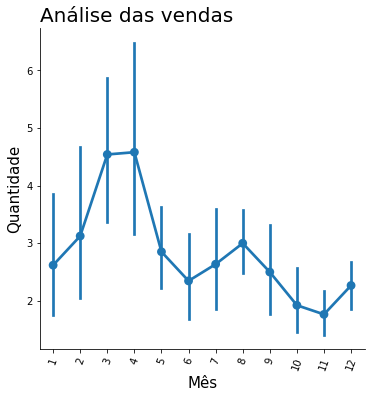

In [25]:

sns.factorplot(x='MES',y='QUANTIDADE',data=dados_features_label)
plt.xlabel("Mês",fontsize=15)
plt.ylabel("Quantidade",fontsize=15)
plt.xticks(rotation=70)
plt.title('Análise das vendas',loc='left',fontsize=20)


#### Descobrindo as melhores variáveis

In [26]:
dados_features_label

,CODIGO_FILIAL,DIA_SEMANA,MES,DIA_MES,CRESCIMENTO,MEDIA_SEMANA,MEDIA_MES,CRESCIMENTO_PERCENTUAL,QUANTIDADE
0,115,4,1,1,0.0,0.000000,0.000000,0.000000,2.0
1,115,6,1,3,0.0,0.000000,0.000000,-0.500000,2.0
2,115,2,1,6,-1.0,0.000000,0.000000,0.000000,1.0
3,115,3,1,7,0.0,0.000000,0.000000,0.000000,1.0
4,115,6,1,10,0.0,0.000000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...
271,115,2,11,4,2.0,1.857143,2.600000,-0.333333,3.0
272,115,5,11,7,-1.0,1.857143,2.533333,0.000000,2.0
273,115,5,11,21,0.0,2.000000,2.533333,0.000000,2.0
274,115,1,12,8,0.0,2.000000,2.533333,0.000000,2.0


In [27]:

clf = ExtraTreesClassifier()
_ = clf.fit(X, y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importancia'] = clf.feature_importances_


In [28]:
features

,feature,importancia
0,CODIGO_FILIAL,0.000000
1,DIA_SEMANA,0.082752
2,MES,0.123450
3,DIA_MES,0.106896
4,CRESCIMENTO,0.182086
5,MEDIA_SEMANA,0.209802
6,MEDIA_MES,0.138975
7,CRESCIMENTO_PERCENTUAL,0.156040


In [29]:
features[features.importancia > np.mean(features.importancia)].sort_values(by='importancia',ascending=False)

,feature,importancia
5,MEDIA_SEMANA,0.209802
4,CRESCIMENTO,0.182086
7,CRESCIMENTO_PERCENTUAL,0.156040
6,MEDIA_MES,0.138975


### Metricas e performance


##### Detecção de uma anomalia por perpectiva supervisionada/não supervisionada

Algoritmo Floresta de Isolamento - Supervisionada


In [30]:
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X,y,train_size=0.75, random_state=23)

In [31]:
Y_dev = Y_dev.apply(lambda x: 1 if x == 0 else -1)
Y_eval = Y_eval.apply(lambda x: 1 if x == 0 else -1)

In [32]:
IF = IsolationForest(max_samples='auto',contamination=0.095,random_state=1)
param_grid = {'n_estimators':[100,150,200,250,300,350,400,450,500]}

clf = GridSearchCV(IF,
                  param_grid,
                  cv=5,
                  n_jobs=10,
                  scoring='f1',
                  verbose=10)

_ = clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   12.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   17.2s
[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed:   23.3s remaining:   10.5s
[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed:   25.0s remaining:    6.2s
[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed:   29.4s remaining:    2.9s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:   29.5s finished


              precision    recall  f1-score   support

     anonimo       1.00      0.09      0.16        69
      normal       0.00      0.00      0.00         0

    accuracy                           0.09        69
   macro avg       0.50      0.04      0.08        69
weighted avg       1.00      0.09      0.16        69



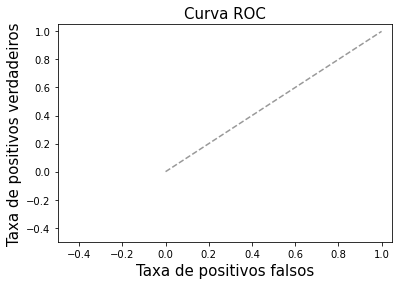

In [33]:
IF_best = clf.best_estimator_
Y_predicted = IF_best.predict(X_eval)
try:
    roc_auc = roc_auc_score(Y_eval, Y_predicted)
    print ('Area sob a curva ROC: {:0.3f}'.format(roc_auc))
except ValueError:
    pass


print(classification_report(Y_eval,
                           Y_predicted,
                           target_names=['anonimo','normal']))


IF_probs = IF_best.decision_function(X_eval)
fpr, tpr, thresold = roc_curve(Y_eval, IF_probs)  

plt.plot(fpr, tpr, lw=1)
plt.plot([0,1],[0,1],'--',color=(0.6,0.6,0.6),label='sorte')
plt.xlim([-0.5,1.05])
plt.ylim([-0.5,1.05])

plt.xlabel('Taxa de positivos falsos',fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros',fontsize=15)
plt.title('Curva ROC',fontsize=15)

plt.show()


In [34]:
cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print(cnf_matrix_IF)

[[ 6 63]
 [ 0  0]]


[[verdadeiro positivo - Falso negativo]

[verdadeiro neggativo - falso positivo]]

pelo teste não foi satisfatório

In [35]:

metrics_df = dados_inicio = dados_produto_filial.copy()
metrics_df.fillna(0, inplace=True)  
metrics_df.columns

#specify the 12 metrics column names to be modelled
to_model_columns=metrics_df[[ 'CODIGO_FILIAL', 'CODIGO_PRODUTO', 
       'SEQUENCIA', 'CRESCIMENTO', 'MEDIA_SEMANA', 'MEDIA_MES',
       'CRESCIMENTO_PERCENTUAL']].columns
to_model_columns

clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), 
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(metrics_df['anomaly'].value_counts())

 1    243
-1     33
Name: anomaly, dtype: int64


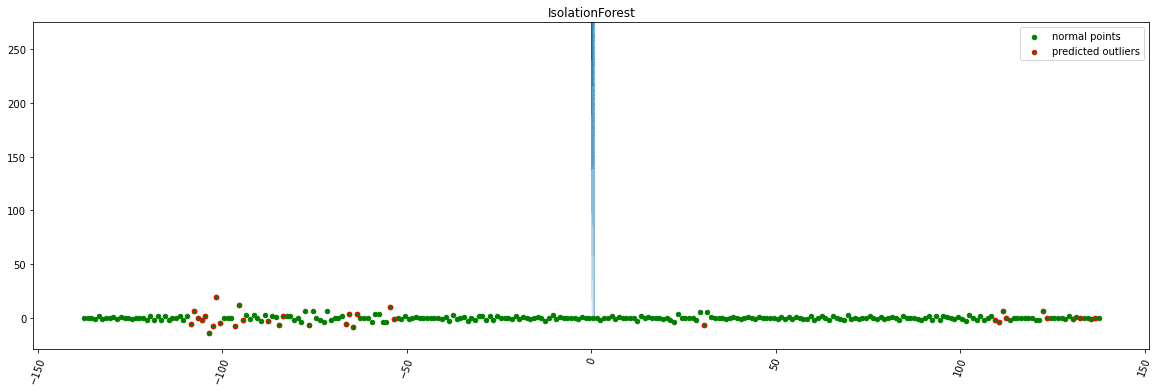

In [36]:

pca = PCA(2)
pca.fit(metrics_df[to_model_columns])
res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
Z = np.array(res)
plt.figure(figsize=(20,6))
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], 
                c='green',s=20,  edgecolor="red",label="predicted outliers")


plt.legend(loc="upper right")
plt.xticks(rotation=70)
plt.show()

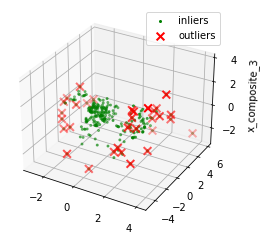

In [37]:



pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics

X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.set_zlabel("x_composite_3")# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")

ax.legend()
plt.show()

#### Usando o algoritmo Linear Regression

In [39]:
dados_inicio = dados_produto_filial.copy()
dados_inicio.fillna(0, inplace=True) 
X = dados_inicio.drop(['DATA_EMISSAO','QUANTIDADE'],axis=1).values 
y = dados_inicio['QUANTIDADE'].values

X_dev, X_eval, Y_dev, Y_eval = train_test_split(X,y,train_size=0.75, random_state=23)

# Cria o objeto linearRegression
linear_regr = LinearRegression().fit(X_dev, Y_dev)

# Make predictions using the testing set
linear_regr_y_pred = linear_regr.predict(X_dev)


# The coefficients
print('Coefficients: \n', linear_regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_dev, linear_regr_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_dev, linear_regr_y_pred))




Coefficients: 
 [ 0.00000000e+00 -4.16333634e-17  2.97033151e-03  4.90463380e-01
  9.68493004e-01 -2.43355360e-01 -2.81991151e-01]
Mean squared error: 2.02
Coefficient of determination: 0.75



### Usando modelo ExtraTreesClassifier

In [40]:
X = dados_features_label.drop(['QUANTIDADE'],axis=1).values 
y = dados_features_label['QUANTIDADE'].values

X_dev, X_eval, Y_dev, Y_eval = train_test_split(X,y,train_size=0.75, random_state=23)

model = ExtraTreesClassifier().fit(X_dev, Y_dev)
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_dev, Y_dev, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))



Accuracy: 0.642 (0.110)


In [41]:

features = pd.DataFrame()
features['feature'] = dados_features_label.drop(['QUANTIDADE'],axis=1).columns
features['importancia'] = model.feature_importances_


In [42]:
features

,feature,importancia
0,CODIGO_FILIAL,0.000000
1,DIA_SEMANA,0.087946
2,MES,0.125775
3,DIA_MES,0.109598
4,CRESCIMENTO,0.178512
5,MEDIA_SEMANA,0.206760
6,MEDIA_MES,0.142933
7,CRESCIMENTO_PERCENTUAL,0.148475


In [43]:
features[features.importancia > np.mean(features.importancia)].sort_values(by='importancia',ascending=False)

,feature,importancia
5,MEDIA_SEMANA,0.206760
4,CRESCIMENTO,0.178512
7,CRESCIMENTO_PERCENTUAL,0.148475
6,MEDIA_MES,0.142933
2,MES,0.125775


### Algoritmo não supervisionado

In [44]:
X_anomalias = dados_features_label[dados_features_label['QUANTIDADE']
                                   .apply(lambda x: True if x in (1,2,3,4) else False)]
X_normal = dados_features_label[dados_features_label['QUANTIDADE']
                                .apply(lambda x: True if x not in (1,2,3,4) else False)]

train_idxs = sample(list(X_normal.index),int(0.7*X_normal.shape[0]))
X_train = X_normal.loc[train_idxs]

X_testing = X_normal.drop(train_idxs)


X_testing = pd.concat([X_testing, X_anomalias],axis=0)

X_train = X_train.sample(frac=1).reset_index(drop=True)
X_testing = X_testing.sample(frac=1).reset_index(drop=True)

Y_testing = X_testing[['QUANTIDADE']]
X_testing = X_testing.drop(['QUANTIDADE'],axis=1)

X_cv, X_eval, Y_cv, Y_eval = train_test_split(X_testing,Y_testing,train_size=0.75, random_state=23)


X_train = X_train.drop(['QUANTIDADE'],axis=1)



In [45]:
X_testing

,CODIGO_FILIAL,DIA_SEMANA,MES,DIA_MES,CRESCIMENTO,MEDIA_SEMANA,MEDIA_MES,CRESCIMENTO_PERCENTUAL
0,115,4,5,17,0.0,3.714286,2.266667,-0.75
1,115,3,4,15,0.0,4.000000,0.000000,-0.50
2,115,4,4,30,0.0,3.428571,0.000000,3.00
3,115,4,4,1,-1.0,1.428571,1.866667,1.00
4,115,2,10,27,0.0,1.285714,2.566667,1.00
...,...,...,...,...,...,...,...,...
249,115,2,4,29,-2.0,8.571429,5.633333,0.00
250,115,1,4,6,0.0,4.571429,0.000000,0.00
251,115,2,10,15,-3.0,3.714286,5.133333,3.00
252,115,3,9,20,-3.0,2.000000,1.666667,0.00


In [46]:
param_grid = {'nu':np.linspace(0.001,0.01,5),'gamma':[0.01,0.03,0.1,0.3]}
param_list = list(itertools.product(param_grid['nu'],param_grid['gamma']))

In [47]:


def random_grid_search(param_list, n_sample, X_train, X_cv, Y_cv):
    f1_max = 0
    param_list = sample(param_list, n_sample)
    remaining_fits = n_sample
    OCSVM_best = None
    
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM( kernel="rbf",nu=nu,gamma=gamma)
        print('Fitando o modelo')
        OCSVM.fit(X_train)
        
        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(Y_cv.values, cv_preds, average='micro')
        
        if f1 > f1_max:
            f1_max = f1        
            OCSVM_best  = OCSVM        
            remaining_fits -= 1
        
            
        if OCSVM_best:
                return f1_max, OCSVM_best
            
    return f1_max, OCSVM
    

f1_max, OCSVM_best = random_grid_search(param_list, 10, X_train, X_cv, Y_cv)        
        
        
        

Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo
Fitando o modelo


In [48]:
OCSVM_best.fit(X_train)
Y_predicated = OCSVM_best.predict(X_eval)

try:
    roc_auc = roc_auc_score(np.argmax(Y_eval, axis = 1), Y_predicted, multi_class='ovo')
    print ('Area sob a curva ROC: {:0.3f}'.format(roc_auc))
    print(classification_report(Y_eval,
                           Y_predicted))

    print ('Area sob a curva ROC: {:0.3f}'.format(roc_auc))

    OCSVM_probs = OCSVM_best.decision_function(X_eval)
    fpr, tpr, thresholds  = roc_curve(Y_eval, OCSVM_probs)    
except ValueError:
    print ('Problema ao calcular o roc_curve')
    pass







Problema ao calcular o roc_curve


              precision    recall  f1-score   support

         1.0       0.74      0.96      0.84        27
         2.0       0.80      0.47      0.59        17
         3.0       1.00      0.33      0.50         3
         4.0       0.76      0.93      0.84        14
         6.0       0.00      0.00      0.00         1
         8.0       1.00      0.50      0.67         2

    accuracy                           0.77        64
   macro avg       0.72      0.53      0.57        64
weighted avg       0.77      0.77      0.74        64

Area sob a curva ROC: 0.936
[[26  1  0  0  0  0]
 [ 8  8  0  1  0  0]
 [ 1  0  1  1  0  0]
 [ 0  1  0 13  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  1  0  1]]


Text(0.5, 1.0, 'Curva ROC')

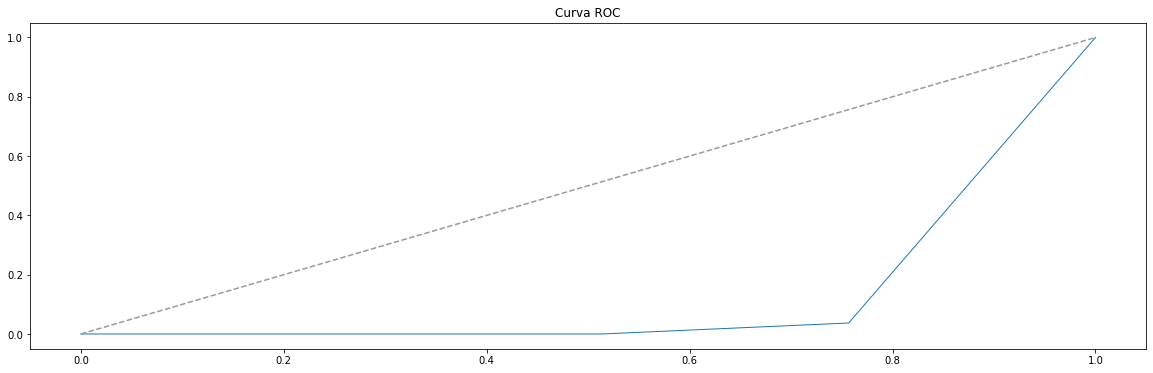

In [49]:



clf = LogisticRegression(solver="liblinear").fit(X_eval, Y_eval)
Y_predicted = clf.predict(X_eval)
roc_auc = roc_auc_score(Y_eval, clf.predict_proba(X_eval), multi_class='ovr')

cv_preds = clf.predict(X_eval)

print(classification_report(Y_eval,
                           Y_predicted))
print ('Area sob a curva ROC: {:0.3f}'.format(roc_auc))

dt_probs = clf.predict_proba(X_eval) 
fpr, tpr, _ = roc_curve(Y_eval, Y_predicted, pos_label=1)

plt.figure(figsize=(20,6))
plt.plot(fpr,tpr,lw=1,label='ROC')
plt.plot([0,1],[0,1],'--',color=(0.6,0.6,0.6),label='sorte')

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

# plt.xlabel('Taxa de positivos falsos',fontsize=15)
# plt.ylabel('Taxa de positivos verdadeiros',fontsize=15)


cnf_matrix_IF = confusion_matrix(Y_eval, Y_predicted)
print(cnf_matrix_IF)


plt.title('Curva ROC')





### Previsão com Keras


In [50]:
dados_keras = dados_produto_filial.copy()
dados_keras.fillna(0, inplace=True)
dados_keras

,DATA_EMISSAO,CODIGO_FILIAL,CODIGO_PRODUTO,QUANTIDADE,SEQUENCIA,CRESCIMENTO,MEDIA_SEMANA,MEDIA_MES,CRESCIMENTO_PERCENTUAL
0,2010-01-01,115,6892,2.0,1,0.0,0.000000,0.000000,0.000000
1,2010-01-03,115,6892,2.0,2,0.0,0.000000,0.000000,-0.500000
2,2010-01-06,115,6892,1.0,3,-1.0,0.000000,0.000000,0.000000
3,2010-01-07,115,6892,1.0,4,0.0,0.000000,0.000000,0.000000
4,2010-01-10,115,6892,1.0,5,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
271,2015-11-04,115,6892,3.0,272,2.0,1.857143,2.600000,-0.333333
272,2015-11-07,115,6892,2.0,273,-1.0,1.857143,2.533333,0.000000
273,2015-11-21,115,6892,2.0,274,0.0,2.000000,2.533333,0.000000
274,2015-12-08,115,6892,2.0,275,0.0,2.000000,2.533333,0.000000


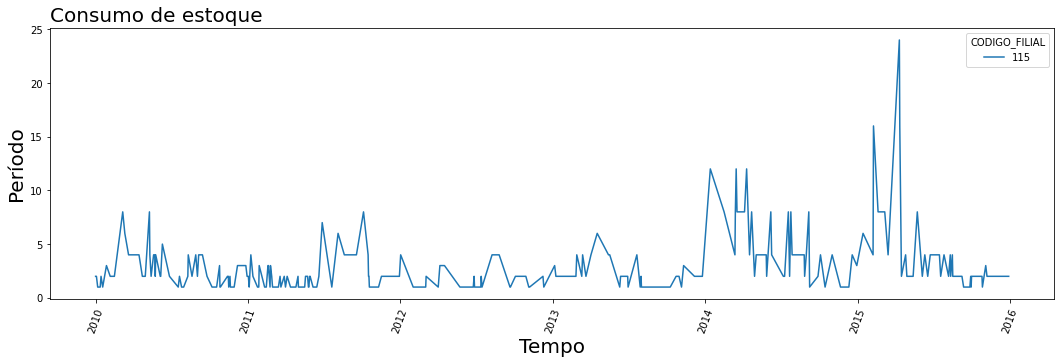

In [51]:

plot_line('Consumo de estoque', 'Tempo',
          'Período', 'DATA_EMISSAO','QUANTIDADE',dados_keras,'CODIGO_FILIAL',None)

In [52]:
sc = StandardScaler()

In [53]:
dados_keras['DATA_EMISSAO_LONG'] = dados_keras['DATA_EMISSAO'].apply(lambda x: x.timestamp())
dados_sc = dados_keras[['DATA_EMISSAO_LONG','QUANTIDADE']]

In [54]:
sc.fit(dados_sc)

StandardScaler()

In [55]:
dado_escalado = sc.transform(dados_sc)

In [56]:
x = dado_escalado[:,0]
y = dado_escalado[:,1]



Text(0, 0.5, '')

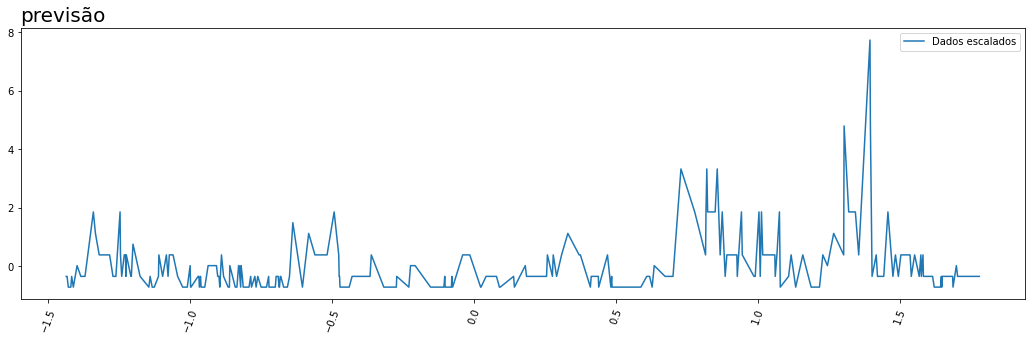

In [57]:
ax = sns.lineplot(x=x,y=y,label='Dados escalados')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

### dividindo o dataset

In [58]:
tamanho_total = len(dado_escalado)
tamanho_treino = int(len(dado_escalado)*0.9)
tamanho_teste = tamanho_total-tamanho_treino

In [59]:
xtreino = x[0:tamanho_treino]
ytreino = y[0:tamanho_treino]

xteste = x[tamanho_treino:tamanho_total]
yteste = y[tamanho_treino:tamanho_total]


Text(0, 0.5, '')

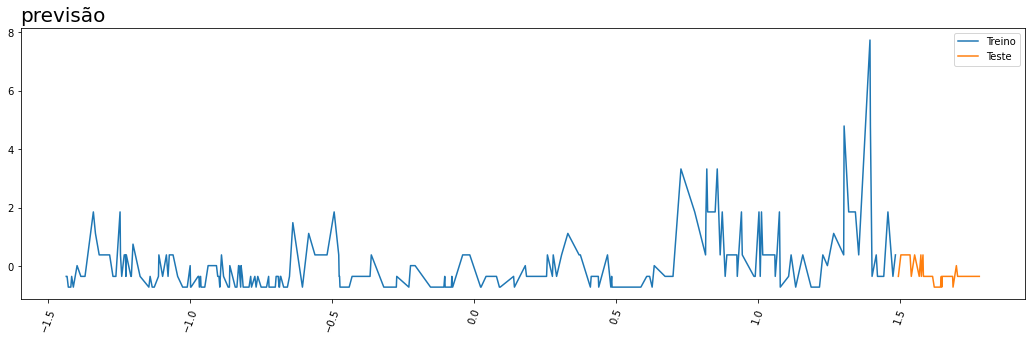

In [60]:
ax = sns.lineplot(x=xtreino,y=ytreino,label='Treino')
sns.lineplot(x=xteste,y=yteste,label='Teste')
plt.ylabel('Quantidade')
plt.xlabel('data')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

#### A cor laranja será o alvo da previsão da rede neural

#### Usando uma rede neural com keras

In [61]:

regressor = Sequential()


In [62]:
# Criando a estrutura da rede iniciando com peso um, usando ativação linear z=Wx+b 
# z= 1 X 0.5 + 0 = 0.05
regressor.add(Dense(1,input_dim=1,kernel_initializer='Ones',activation='linear',use_bias=False))

In [63]:
#Compilando a estrutura da rede, usando o algoritmo de otimização adam
regressor.compile(loss='mean_squared_error',optimizer='adam')

In [64]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


In [65]:
regressor.fit(xtreino, ytreino)

8/8 [==============================] - 0s 2ms/step - loss: 1.2228


In [66]:
y_predict = regressor.predict(xtreino)

Text(0, 0.5, '')

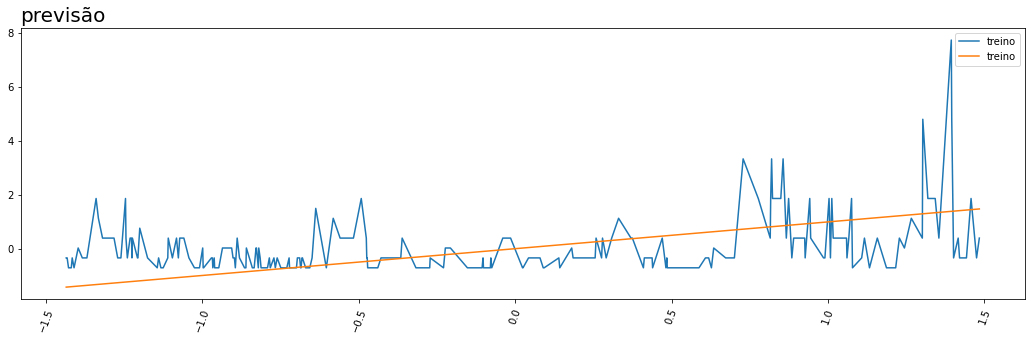

In [67]:
ax = sns.lineplot(x=xtreino,y=ytreino,label='treino')
sns.lineplot(x=xtreino,y=y_predict[:,0],label='treino')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

In [68]:
d = {'tempo': xtreino, 'quantidade':y_predict[:,0]}

In [69]:
resultados = pd.DataFrame(data=d)

In [71]:
resultado_transf = sc.inverse_transform(resultados)

In [72]:
resultado_transf = pd.DataFrame(resultado_transf)

In [73]:
resultado_transf.columns = ['tempo','quantidade']

Text(0, 0.5, '')

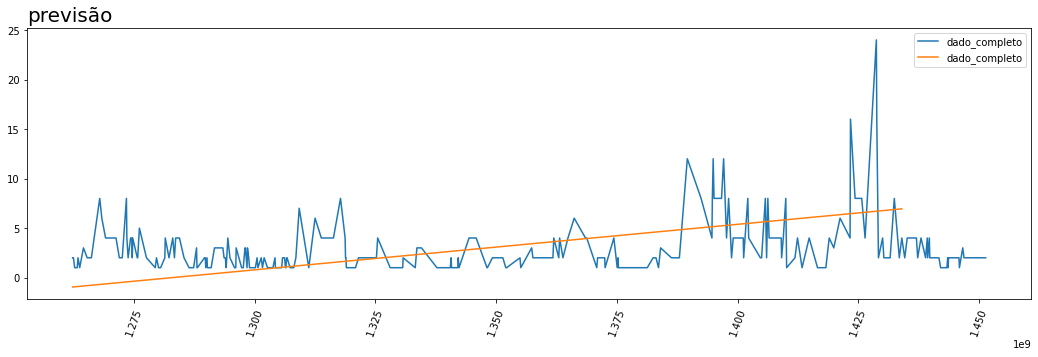

In [74]:
ax = sns.lineplot(x='DATA_EMISSAO_LONG',y='QUANTIDADE',data= dados_sc, label='dado_completo')
sns.lineplot(x='tempo',y='quantidade',data= resultado_transf, label='dado_completo')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

### fazendo um previsão

In [75]:
y_predict_teste = regressor.predict(xteste)

In [76]:
d_teste = {'tempo': xteste, 'quantidade':y_predict_teste[:,0]}
resultado_teste = pd.DataFrame(data=d_teste)

In [77]:
resultado_transf_teste = sc.inverse_transform(resultado_teste)

In [78]:
resultado_transf_teste = pd.DataFrame(resultado_transf_teste)

In [79]:
resultado_transf_teste.columns = ['tempo','quantidade']

Text(0, 0.5, '')

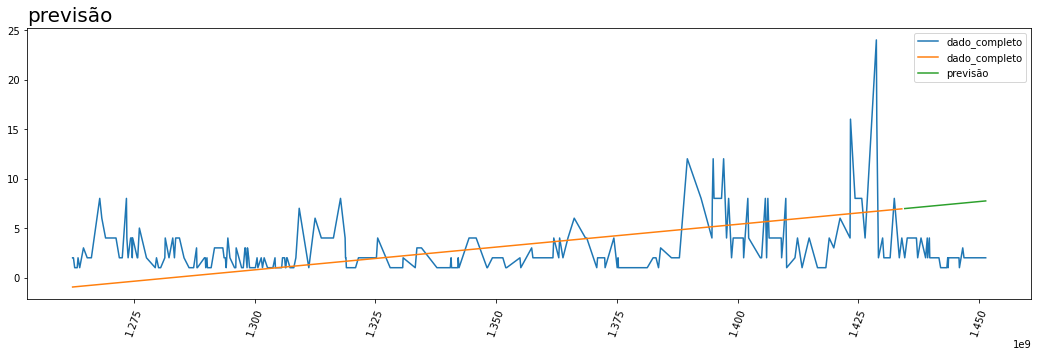

In [80]:
ax = sns.lineplot(x='DATA_EMISSAO_LONG',y='QUANTIDADE',data= dados_sc, label='dado_completo')
sns.lineplot(x='tempo',y='quantidade',data= resultado_transf, label='dado_completo')
sns.lineplot(x='tempo',y='quantidade',data= resultado_transf_teste, label='previsão')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

### Adicionando mais camadas com mais neuronios com multiplas camadas

In [81]:
regressor2 = Sequential()

In [82]:
#trabalhando com 8 neuronios com duas camadas escondidas
regressor2.add(Dense(8, input_dim=1,
                     kernel_initializer='random_uniform',activation='linear',use_bias=False))
regressor2.add(Dense(8, 
                     kernel_initializer='random_uniform',activation='linear',use_bias=False))
regressor2.add(Dense(1, 
                     kernel_initializer='random_uniform',activation='linear',use_bias=False))

In [83]:
#Compilando a estrutura da rede, usando o algoritmo de otimização adam
regressor2.compile(loss='mean_squared_error',optimizer='adam')

In [84]:
regressor2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [85]:
regressor2.fit(xtreino, ytreino, epochs=200)

Epoch 1/200
8/8 [==============================] - 0s 965us/step - loss: 1.0914
Epoch 2/200
8/8 [==============================] - 0s 944us/step - loss: 1.0910
Epoch 3/200
8/8 [==============================] - 0s 1ms/step - loss: 1.0902
Epoch 4/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0889
Epoch 5/200
8/8 [==============================] - 0s 696us/step - loss: 1.0866
Epoch 6/200
8/8 [==============================] - 0s 1ms/step - loss: 1.0832
Epoch 7/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0778
Epoch 8/200
8/8 [==============================] - 0s 1ms/step - loss: 1.0713
Epoch 9/200
8/8 [==============================] - 0s 954us/step - loss: 1.0620
Epoch 10/200
8/8 [==============================] - 0s 2ms/step - loss: 1.0507
Epoch 11/200
8/8 [==============================] - 0s 1ms/step - loss: 1.0363
Epoch 12/200
8/8 [==============================] - 0s 1ms/step - loss: 1.0219
Epoch 13/200
8/8 [==============================] - 0

In [86]:
y_predict = regressor2.predict(xtreino)
y_predict_teste = regressor2.predict(xteste)


Text(0, 0.5, '')

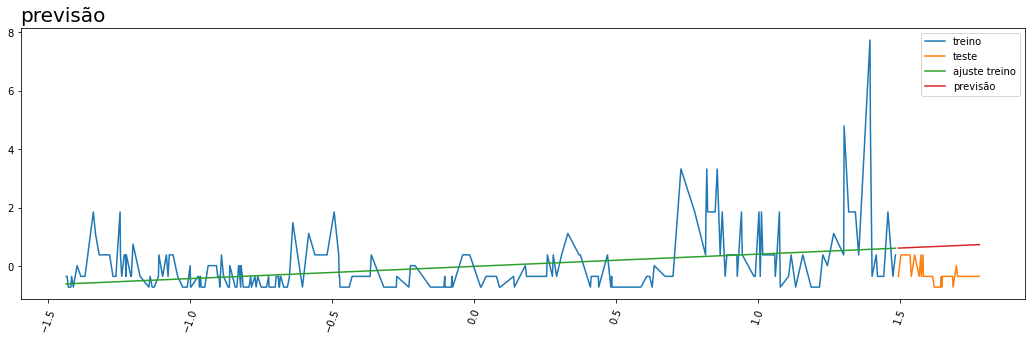

In [87]:
ax = sns.lineplot(x=xtreino,y=ytreino,label='treino')
sns.lineplot(x=xteste,y=yteste,label='teste')
sns.lineplot(x=xtreino,y=y_predict[:,0],label='ajuste treino')
sns.lineplot(x=xteste,y=y_predict_teste[:,0],label='previsão')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

#### Validando as possibilidades futura


In [88]:
vetor = pd.DataFrame(ytreino)[0]

In [89]:

def split_data(vetor, n_passos):
    X_novo, Y_novo = [], []
    
    for indices in range(n_passos, vetor.shape[0]):
        X_novo.append(list(vetor.loc[indices-n_passos:indices-1]))
        Y_novo.append(vetor.loc[indices])
    X_novo, Y_novo = np.array(X_novo), np.array(Y_novo)
    return X_novo, Y_novo
    

In [90]:
xtreino_novo, ytreino_novo = split_data(vetor,1)

In [91]:
xtreino_novo[0:5]

array([[-0.34169158],
       [-0.34169158],
       [-0.7086444 ],
       [-0.7086444 ],
       [-0.7086444 ]])

In [92]:
ytreino_novo[0:5]

array([-0.34169158, -0.7086444 , -0.7086444 , -0.7086444 , -0.7086444 ])

In [93]:
vetor2 = pd.DataFrame(yteste)[0]

In [94]:
xteste_novo, yteste_novo = split_data(vetor2,1)

In [95]:
regressor3 = Sequential()

In [96]:
#trabalhando com 8 neuronios com duas camadas escondidas
regressor3.add(Dense(8, input_dim=1,
                     kernel_initializer='ones',activation='linear',use_bias=False))
regressor3.add(Dense(64, input_dim=1,
                     kernel_initializer='random_uniform',activation='sigmoid',use_bias=False))
regressor3.add(Dense(1, 
                     kernel_initializer='random_uniform',activation='linear',use_bias=False))


In [97]:
#Compilando a estrutura da rede, usando o algoritmo de otimização adam
regressor3.compile(loss='mean_squared_error',optimizer='adam')

In [98]:
regressor3.fit(xtreino_novo,ytreino_novo,epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.1141
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 1.0716
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0542
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 1.0376
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 1.0187
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 1.0023
Epoch 7/100
8/8 [==============================] - 0s 897us/step - loss: 0.9851
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9650
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9464
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 0.9292
Epoch 11/100
8/8 [==============================] - 0s 785us/step - loss: 0.9174
Epoch 12/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9003
Epoch 13/100
8/8 [==============================] - 0s 1m

In [99]:
y_predict_novo = regressor3.predict(xtreino_novo)

Text(0, 0.5, '')

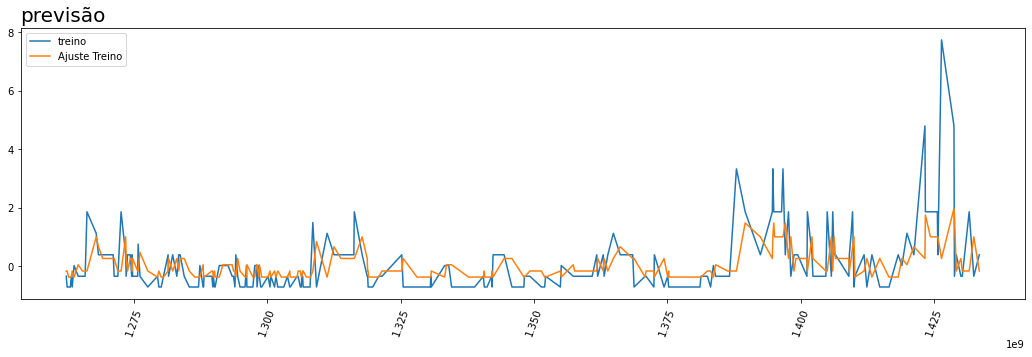

In [103]:
ax = sns.lineplot(x='DATA_EMISSAO_LONG',y=ytreino_novo,data= dados_sc[0:ytreino_novo.size], label='treino')
sns.lineplot(x='DATA_EMISSAO_LONG',y=pd.DataFrame(y_predict_novo)[0],data= dados_sc[0:y_predict_novo.size], label='Ajuste Treino')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

Text(0, 0.5, '')

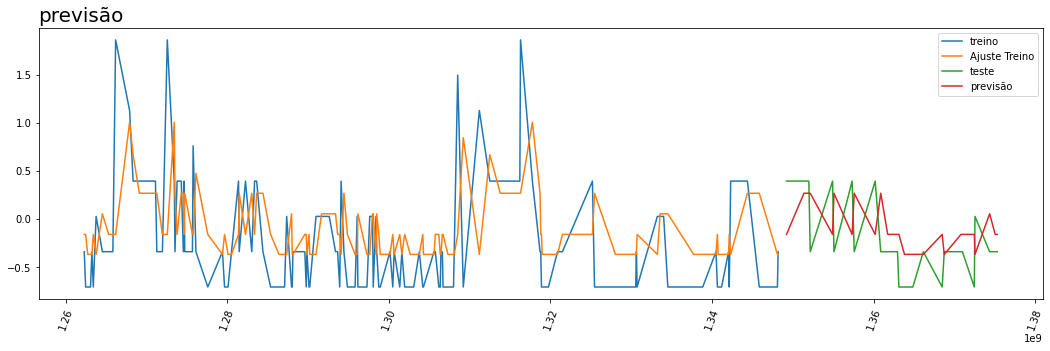

In [104]:

y_predict_teste_novo = regressor3.predict(xteste_novo)
resultado_novo = pd.DataFrame(y_predict_teste_novo)[0]
ax = sns.lineplot(x='DATA_EMISSAO_LONG',y=ytreino_novo[0:152],data= dados_sc[0:152], label='treino')
sns.lineplot(x='DATA_EMISSAO_LONG',y=pd.DataFrame(y_predict_novo[0:152])[0],data= dados_sc[0:152], label='Ajuste Treino')
sns.lineplot(x='DATA_EMISSAO_LONG',y=yteste_novo,data= dados_sc[152:179], label='teste')
sns.lineplot(x='DATA_EMISSAO_LONG',y=resultado_novo.values,data= dados_sc[152:179], label='previsão')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

In [105]:
xtreino_novo1, ytreino_novo1 = split_data(vetor,4)

In [106]:
xteste_novo1, yteste_novo1 = split_data(vetor2,4)

In [107]:
regressor4 = Sequential()

In [108]:
#trabalhando com 8 neuronios com duas camadas escondidas, alterando o DIM para 4 conforme o split
regressor4.add(Dense(8, input_dim=4,
                     kernel_initializer='ones',activation='linear',use_bias=False))
regressor4.add(Dense(64, input_dim=1,
                     kernel_initializer='random_uniform',activation='sigmoid',use_bias=False))
regressor4.add(Dense(1, 
                     kernel_initializer='random_uniform',activation='linear',use_bias=False))


In [109]:
#Compilando a estrutura da rede, usando o algoritmo de otimização adam
regressor4.compile(loss='mean_squared_error',optimizer='adam')

In [110]:
regressor4.fit(xtreino_novo1, ytreino_novo1, epochs=600)

Epoch 1/600
8/8 [==============================] - 0s 2ms/step - loss: 1.0620
Epoch 2/600
8/8 [==============================] - 0s 1ms/step - loss: 0.9821
Epoch 3/600
8/8 [==============================] - 0s 1ms/step - loss: 0.9213
Epoch 4/600
8/8 [==============================] - 0s 2ms/step - loss: 0.8709
Epoch 5/600
8/8 [==============================] - 0s 1ms/step - loss: 0.8276
Epoch 6/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7980
Epoch 7/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7792
Epoch 8/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7744
Epoch 9/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7666
Epoch 10/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7671
Epoch 11/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7655
Epoch 12/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7666
Epoch 13/600
8/8 [==============================] - 0s 2ms/st

8/8 [==============================] - 0s 2ms/step - loss: 0.7571
Epoch 207/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7558
Epoch 208/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7556
Epoch 209/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7560
Epoch 210/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7561
Epoch 211/600
8/8 [==============================] - 0s 946us/step - loss: 0.7548
Epoch 212/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7561
Epoch 213/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7545
Epoch 214/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7546
Epoch 215/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7549
Epoch 216/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7547
Epoch 217/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7546
Epoch 218/600
8/8 [==============================] -

Epoch 409/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7557
Epoch 410/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7527
Epoch 411/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7526
Epoch 412/600
8/8 [==============================] - ETA: 0s - loss: 0.336 - 0s 1ms/step - loss: 0.7569
Epoch 413/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7537
Epoch 414/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7541
Epoch 415/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7542
Epoch 416/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7532
Epoch 417/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7558
Epoch 418/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7586
Epoch 419/600
8/8 [==============================] - ETA: 0s - loss: 0.580 - 0s 2ms/step - loss: 0.7551
Epoch 420/600
8/8 [==============================] - 0s 1ms/step - loss:

Epoch 510/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7540
Epoch 511/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7543
Epoch 512/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7531
Epoch 513/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7534
Epoch 514/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7530
Epoch 515/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7550
Epoch 516/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7542
Epoch 517/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7542
Epoch 518/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7541
Epoch 519/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7526
Epoch 520/600
8/8 [==============================] - 0s 1ms/step - loss: 0.7537
Epoch 521/600
8/8 [==============================] - 0s 2ms/step - loss: 0.7545
Epoch 522/600
8/8 [=====================

In [111]:
y_predict_novo1 = regressor4.predict(xtreino_novo1)

In [112]:
y_predict_teste_novo1 = regressor4.predict(xteste_novo1)

In [113]:
resultado_teste_novo1 = pd.DataFrame(y_predict_teste_novo1)[0]

Text(0, 0.5, '')

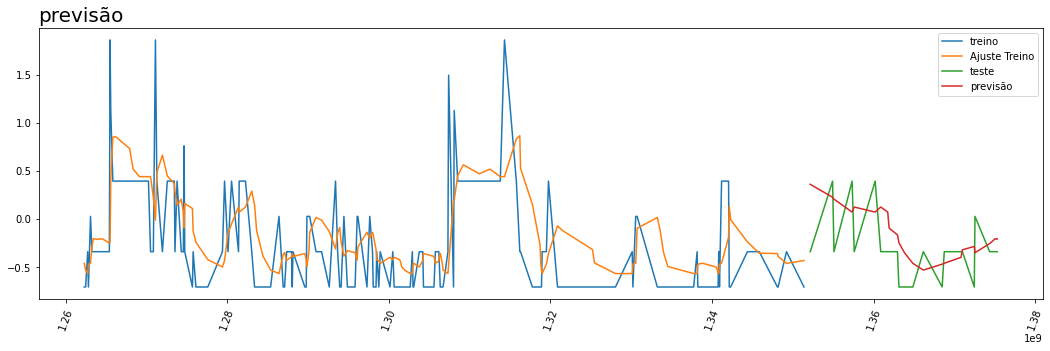

In [114]:
ax = sns.lineplot(x='DATA_EMISSAO_LONG',y=ytreino_novo1[0:154],data= dados_sc[0:154], label='treino')
sns.lineplot(x='DATA_EMISSAO_LONG',y=pd.DataFrame(y_predict_novo1[0:154])[0],data= dados_sc[0:154], label='Ajuste Treino')
sns.lineplot(x='DATA_EMISSAO_LONG',y=yteste_novo1,data= dados_sc[155:179], label='teste')
sns.lineplot(x='DATA_EMISSAO_LONG',y=resultado_teste_novo1.values,data= dados_sc[155:179], label='previsão')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel(""  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

### Rede recorrente com LSTM -> Long Short Term Memory

In [115]:
#dados_analise_recorrente = dados_produto_filial[['DATA_EMISSAO','QUANTIDADE']].copy()
dados_analise_recorrente = dados_produto_filial.copy()

Text(0, 0.5, '')

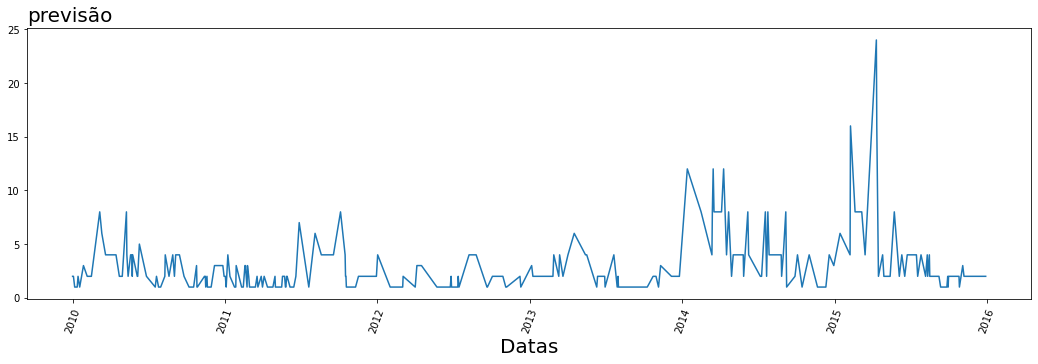

In [116]:
#Precisa de dados com 3 dimensões 
ax = sns.lineplot(x='DATA_EMISSAO', y= 'QUANTIDADE', data = dados_analise_recorrente)
plt.xticks(rotation=70)

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel("Datas"  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

In [117]:
sc2 = StandardScaler()

In [118]:
sc2.fit(dados_analise_recorrente['QUANTIDADE'].values.reshape(-1,1))

StandardScaler()

In [119]:
y = sc2.transform(dados_analise_recorrente['QUANTIDADE'].values.reshape(-1,1))

In [120]:
tamanho = len(dados_analise_recorrente)
tamanho_treino = int(tamanho*0.9)
tamanho_teste = tamanho-tamanho_treino


Text(0, 0.5, '')

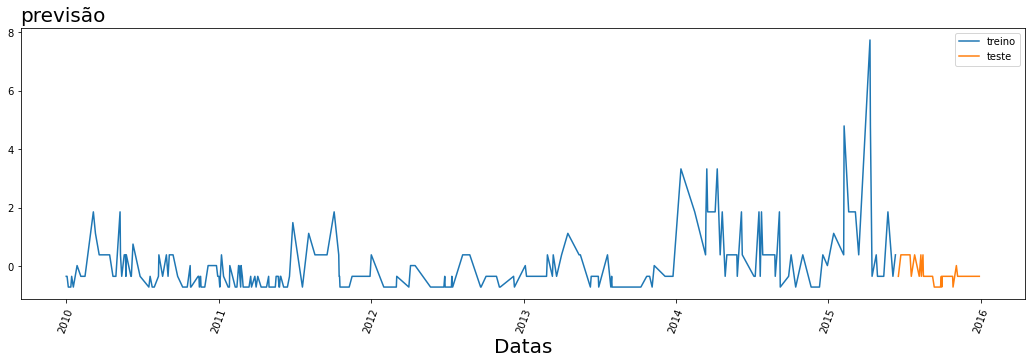

In [121]:
ax = sns.lineplot(x='DATA_EMISSAO', y= ytreino, data = dados_analise_recorrente[0:tamanho_treino],label = 'treino')
sns.lineplot(x='DATA_EMISSAO', y= yteste, data = dados_analise_recorrente[tamanho_treino:tamanho],label = 'teste')


plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel("Datas"  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

In [122]:
vetor_treino = pd.DataFrame(ytreino)[0]
xtreino_novo_recorr, ytreino_novo_recorr = split_data(vetor_treino,10)

In [123]:
vetor_teste = pd.DataFrame(ytreino)[0]
xteste_novo_recorr, yteste_novo_recorr = split_data(vetor_teste,10)

In [124]:
xtreino_novo_recorr = xtreino_novo_recorr.reshape((xtreino_novo_recorr.shape[0],xtreino_novo_recorr.shape[1],1))

In [125]:
xteste_novo_recorr = xteste_novo_recorr.reshape((xteste_novo_recorr.shape[0],xteste_novo_recorr.shape[1],1))

In [126]:
recorrente = Sequential()

In [127]:
# LSTM rede recorrente eirá usar loop com 128 iterações
recorrente.add(LSTM(128,input_shape=(xtreino_novo_recorr.shape[1],xtreino_novo_recorr.shape[2])))
recorrente.add(Dense(units=1))

In [128]:
recorrente.compile(loss='mean_squared_error',optimizer='RMSProp')

In [129]:
recorrente.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [130]:
resultado_recorrente = recorrente.fit(xtreino_novo_recorr,
                                      ytreino_novo_recorr,
                                      validation_data=(xteste_novo_recorr,yteste_novo_recorr),
                                      epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 128ms/step - loss: 0.9461 - val_loss: 0.8892
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 0.8667 - val_loss: 0.8382
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 0.8504 - val_loss: 0.8182
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 0.8281 - val_loss: 0.8056
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.8110 - val_loss: 0.7865
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 0.8048 - val_loss: 0.7931
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 0.7885 - val_loss: 0.7750
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 0.7826 - val_loss: 0.7664
Epoch 9/100
8/8 [==============================] - 0s 26ms/step - loss: 0.7860 - val_loss: 0.7587
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 0.7665 - val_loss: 0.7698
Epoch 11/100
8/8 [

Epoch 84/100
8/8 [==============================] - 0s 22ms/step - loss: 0.5907 - val_loss: 0.5569
Epoch 85/100
8/8 [==============================] - 0s 22ms/step - loss: 0.5848 - val_loss: 0.6644
Epoch 86/100
8/8 [==============================] - 0s 21ms/step - loss: 0.6090 - val_loss: 0.5460
Epoch 87/100
8/8 [==============================] - 0s 23ms/step - loss: 0.5846 - val_loss: 0.5552
Epoch 88/100
8/8 [==============================] - 0s 23ms/step - loss: 0.5658 - val_loss: 0.5684
Epoch 89/100
8/8 [==============================] - 0s 22ms/step - loss: 0.5806 - val_loss: 0.6021
Epoch 90/100
8/8 [==============================] - 0s 22ms/step - loss: 0.5809 - val_loss: 0.5356
Epoch 91/100
8/8 [==============================] - 0s 22ms/step - loss: 0.5764 - val_loss: 0.5841
Epoch 92/100
8/8 [==============================] - 0s 23ms/step - loss: 0.5729 - val_loss: 0.5315
Epoch 93/100
8/8 [==============================] - 0s 27ms/step - loss: 0.5504 - val_loss: 0.5385
Epoch 94/1

In [131]:
y_ajustado_recorrente = recorrente.predict(xtreino_novo_recorr)

Text(0, 0.5, '')

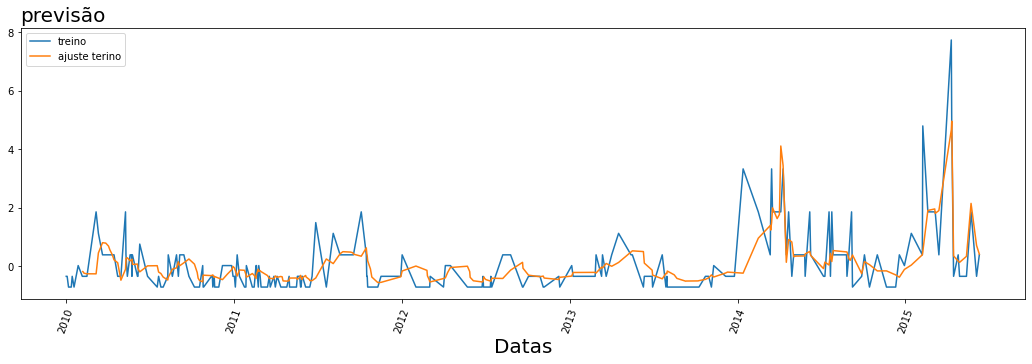

In [132]:
ax = sns.lineplot(x='DATA_EMISSAO', y= ytreino, data = dados_analise_recorrente[0:tamanho_treino],label = 'treino')
sns.lineplot(x='DATA_EMISSAO', y= y_ajustado_recorrente[:,0], data = dados_analise_recorrente[10:tamanho_treino],label = 'ajuste terino')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel("Datas"  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

In [133]:
y_predict_recorrente = recorrente.predict(xteste_novo_recorr)

Text(0, 0.5, '')

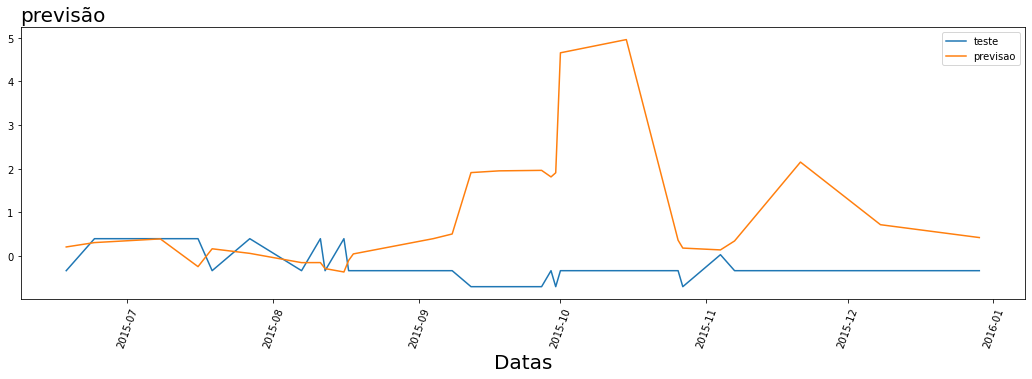

In [134]:

#xteste_novo_recorr,yteste_novo_recorr
ax = sns.lineplot(x='DATA_EMISSAO', y= yteste, data = dados_analise_recorrente[-tamanho_teste:],label = 'teste')
sns.lineplot(x='DATA_EMISSAO', y= y_predict_recorrente[-tamanho_teste:,0], 
             data = dados_analise_recorrente[tamanho_treino:],label = 'previsao')

plt.xticks(rotation=70)
ax.figure.set_size_inches(18,5)
ax.set_title("previsão", loc='left',fontsize=20)
ax.set_xlabel("Datas"  ,fontsize=20)
ax.set_ylabel("",fontsize=20, rotation=90)

In [135]:
print(resultado_recorrente.history.keys())

dict_keys(['loss', 'val_loss'])


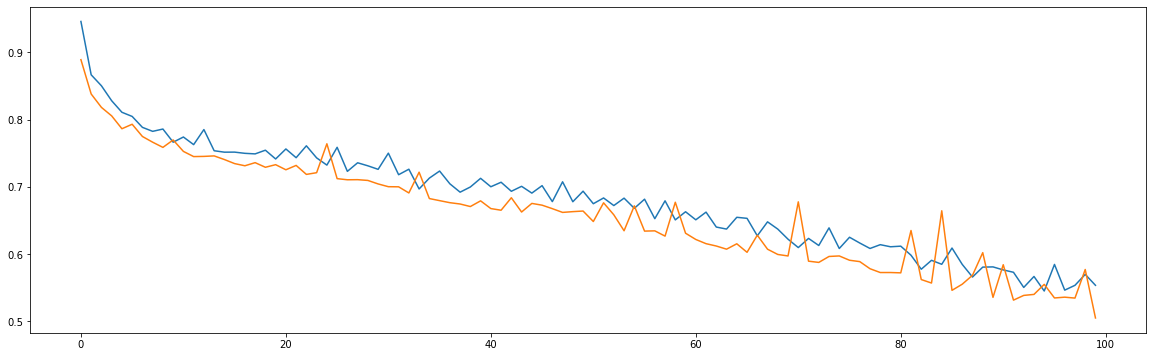

In [137]:
plt.figure(figsize=(20,6))
plt.plot(resultado_recorrente.history['loss'])
plt.plot(resultado_recorrente.history['val_loss'])


#### Acima temos a avaliação do custo dos teste e que mostra que o resultado é considerado bom pois os valor está diminuindo para as duas massas. Se caso uma estivesse sobressaindo a outra é sinal que temos um overfitting